In [1]:
% matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import json
import matplotlib.gridspec as gridspec
import copy
import seaborn as sns
from scipy.stats import ttest_1samp
import sys
sys.path.append('..')
from helpers.glove_neighbors import *
from helpers.funcs import *

In [2]:
config = json.load(open('../config.json', 'r'))
DATA_DIR = config['DATA_DIR']
TWEET_DIR = config['TWEET_DIR']
NUM_CLUSTERS = config['NUM_CLUSTERS']
events = open(DATA_DIR + 'event_names.txt', 'r').read().splitlines()

In [52]:
#cluster_method = '_relative'
cluster_method = ''

In [3]:
means = np.load(DATA_DIR + 'cluster_6_means.npy')
glove = pd.read_csv(DATA_DIR+'glove.50d.csv', sep='\t', index_col=0)

In [9]:
for m in means:
    print(neighbors_vector(m, glove).head(25))
    print('-----')

solv             0.586853
argument         0.593100
eat              0.607621
yeah             0.608151
aren             0.618089
nobodi           0.620788
logic            0.623440
fix              0.623818
abid             0.625091
kid              0.627249
mayb             0.629764
wouldn           0.630395
#gunreform       0.631049
problem          0.631625
dont             0.631626
shouldn          0.632452
realiz           0.633079
sensibl          0.635363
unless           0.638790
harder           0.638945
stupid           0.643029
access           0.644293
#gunreformnow    0.644529
better           0.648661
worri            0.649712
dtype: float64
-----
affect         0.350485
senseless      0.382409
ach            0.413394
sadden         0.416524
heart          0.427132
#prayer        0.447073
deepest        0.448905
pray           0.449274
heartbroken    0.452167
loss           0.463904
bless          0.469802
prayer         0.473960
famili         0.484052
condol         0.

In [56]:
cluster_names = {0: "laws & policy",
 1: 'solidarity',
 2: 'news',
 3: 'remembrance',
 4: 'investigation',
 5: 'ideology'}

# topic proportions

In [29]:
cluster_proportions = {i:[] for i in range(NUM_CLUSTERS)}
for event in events:
    labels = np.load(TWEET_DIR + event + '/' + event + '_cluster_labels_'+str(NUM_CLUSTERS)+cluster_method+'.npy')
    props = np.bincount(labels) / np.sum(np.bincount(labels))
    for i, j in enumerate(props):
        cluster_proportions[i].append(j)

In [30]:
for k, v in cluster_proportions.items():
    print(cluster_names[k], np.mean(v))

laws &
policy 0.27658950309864083
solidarity 0.14368054465217056
news 0.19333874310655666
remembrance 0.09063644659728616
investigation 0.12237513172638266
ideology 0.17337963081896313


# topic log odds

In [31]:
shooter_race = json.load(open(DATA_DIR + "shooters_race.json","r"))

In [33]:
event_list = []
log_odds_list = []
topic_list = []
race = []
for event in events:
    print(event)
    event_list.extend([event] * NUM_CLUSTERS)
    data = pd.read_csv(TWEET_DIR + event + '/' + event + '.csv', sep='\t', lineterminator='\n',usecols=['dem_follows', 'rep_follows'])
    data = filter_clustered_tweets(event, data, TWEET_DIR, cluster_method[1:])
    data['topic'] = get_clusters(event, TWEET_DIR, cluster_method[1:], NUM_CLUSTERS)
    dem, rep = split_party(data)
    dem_prop = len(dem) / len(data)
    rep_prop = len(rep) / len(data)
    
    for i in range(NUM_CLUSTERS):
        dem_cluster = (dem['topic']==i).sum()
        rep_cluster = (rep['topic']==i).sum()
        total_cluster = dem_cluster + rep_cluster
        dem_val = dem_cluster / (len(dem) - dem_cluster)
        rep_val = rep_cluster / (len(rep) - rep_cluster)
        topic_list.append(cluster_names[i])
        log_odds_list.append(np.log(rep_val / dem_val))
        race.append(shooter_race[event])
        print(cluster_names[i], 'odds', np.log(rep_val / dem_val))
        
    print()
    print('------')
    

chattanooga
laws &
policy odds 0.047940199734022006
solidarity odds -0.25512118170155473
news odds -0.18991519182699815
remembrance odds 0.4390654066565601
investigation odds 0.014653498234925769
ideology odds 0.054321671012759656

------
roseburg
laws &
policy odds -0.10019617995478594
solidarity odds -0.2754918567309178
news odds 0.10318690263525736
remembrance odds -0.08720078638645755
investigation odds 0.4801425525883404
ideology odds 0.8627365586982537

------
colorado_springs
laws &
policy odds -0.03292904346721173
solidarity odds -0.011446965735397305
news odds 0.8547130073239136
remembrance odds -0.1520851069248146
investigation odds 0.4851703680491336
ideology odds -0.51383735322371

------
san_bernardino
laws &
policy odds -0.26804581240076525
solidarity odds -0.4747527638533643
news odds -0.08401734160710432
remembrance odds -0.1750241054030777
investigation odds 0.1502471966025785
ideology odds 0.6346831499465907

------
kalamazoo
laws &
policy odds -0.47603159097543934
so

In [34]:
df = pd.DataFrame.from_dict({'event':event_list, 'topic':topic_list, 'log_odds':log_odds_list, 'race':race})

In [35]:
for i, g in df.groupby('topic'):
    print(i)
    print(ttest_1samp(np.array(g['log_odds']), 0))

ideology
Ttest_1sampResult(statistic=1.4660488055728131, pvalue=0.15818187274548517)
investigation
Ttest_1sampResult(statistic=3.9281535359385655, pvalue=0.0008321830559979761)
laws &
policy
Ttest_1sampResult(statistic=-5.91780183449416, pvalue=8.679355192156348e-06)
news
Ttest_1sampResult(statistic=2.7510465667332804, pvalue=0.012317943101524563)
remembrance
Ttest_1sampResult(statistic=-1.0021846667691756, pvalue=0.32822634151270746)
solidarity
Ttest_1sampResult(statistic=-5.3249356237317835, pvalue=3.271629657556508e-05)


[None, None]

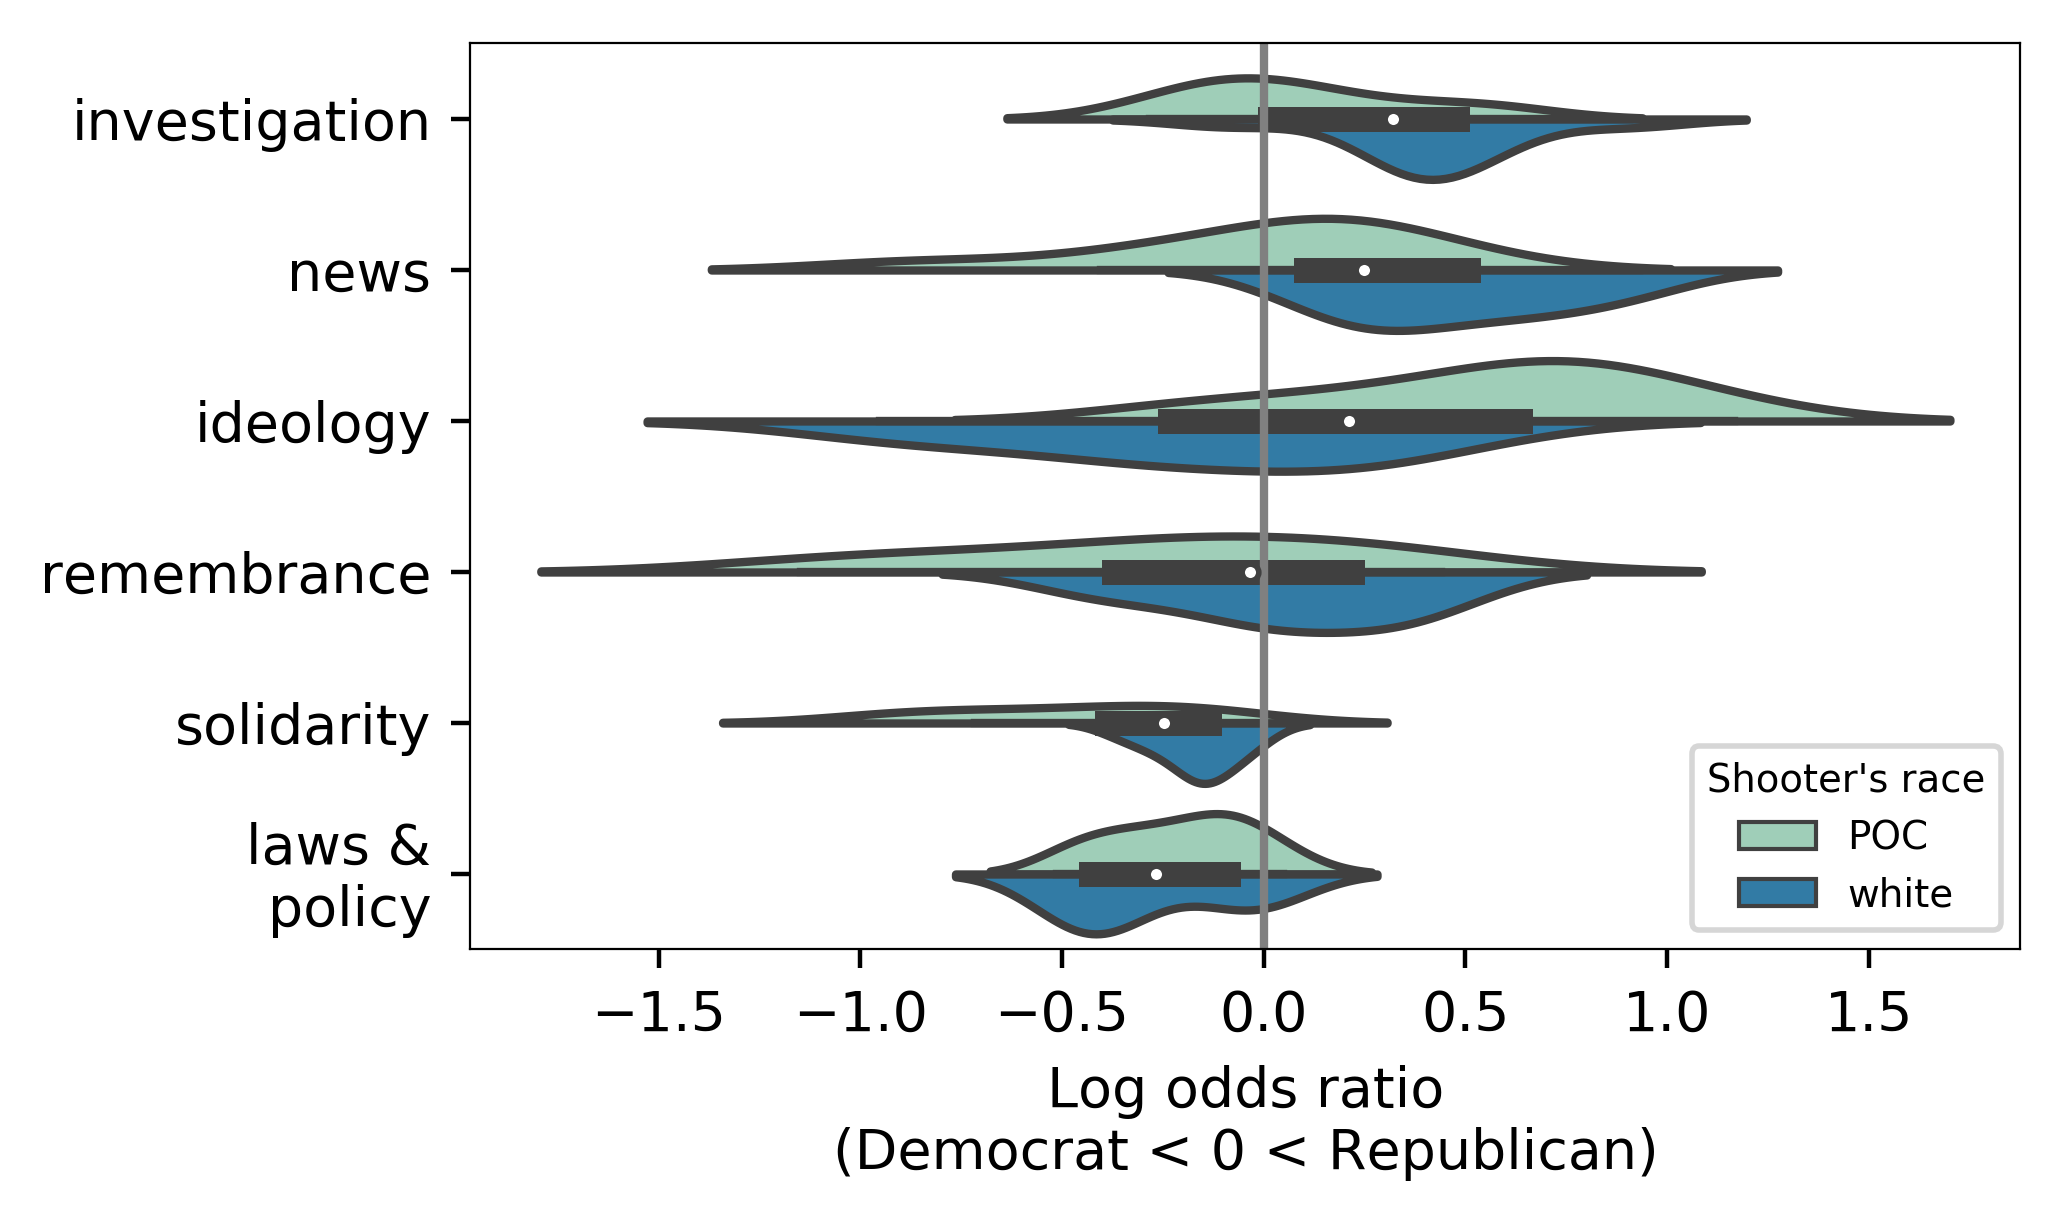

In [36]:
f = plt.figure(dpi=400, edgecolor='grey', figsize=(5,3))
ax = sns.violinplot(data=df, x="log_odds",y="topic", hue='race', split=True, order=reversed(df.groupby('topic').median().sort_values('log_odds').index), orient="h", palette=sns.color_palette("YlGnBu", 2))
ax.set_ylabel('')
ax.spines['top'].set_linewidth(0.4)
ax.spines['right'].set_linewidth(0.4)
ax.spines['bottom'].set_linewidth(0.4)
ax.spines['left'].set_linewidth(0.4)
ax.set_xlabel('Log odds ratio\n(Democrat < 0 < Republican)')
plt.axvline(x=0, color='grey')
legend = plt.legend(title="Shooter's race", fontsize=7, loc='lower right')
plt.setp(legend.get_title(),fontsize='x-small')

# plot topic polarization over time

In [37]:
hour = 60 * 60
day = 24 * hour
split_by = 12 * hour
no_splits = int((day / split_by) * 14)  # 14 days

In [48]:
def get_buckets(data, timestamp):
    '''Divide tweets into time buckets.'''
    timestamps = data['timestamp'].astype(float)
    buckets = []
    start = timestamp
    for i in range(no_splits):
        new_start = start + split_by
        b = data[(timestamps > start) & (timestamps < new_start)]
        start = new_start
        buckets.append(b)
    return buckets

In [49]:
def plot_clusters(events):
    '''Plot polarization over time (average value for all the events in params). We only use ["vegas"] in the paper.'''
    num_splits = 18 # 9 days (splits are made ever 12 hours)
    T = (np.arange(num_splits) + 1) / 2 
    freqs = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # topic frequencies
    actual = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # actual leaveout value
    random = np.zeros((num_splits, NUM_CLUSTERS, len(events)))  # random leaveout value
    for k, e in enumerate(events):
        pol = json.load(open(TWEET_DIR + e + '/' + e + '_topic_polarization_overtime'+cluster_method+'.json', 'r'))
        for i in range(num_splits):
            for j in range(NUM_CLUSTERS):
                freqs[i, j, k] = int(pol[str(i)][str(j)][2])
                actual[i, j, k] = float(pol[str(i)][str(j)][0])
                random[i, j, k] = float(pol[str(i)][str(j)][1])
            freqs[i, :, k] = freqs[i, :, k] / np.sum(freqs[i, :, k])  # turn frequencies into topic proportions
        
    mean_freqs = np.mean(freqs, axis=2)
    mean_actual = np.mean(actual, axis=2)
    mean_random = np.mean(random, axis=2)
    
    ro = {0:0, 1:2, 2:3, 3:4, 4:1, 5:5}   # order of plots (i.e. topics), order in plot (key): topic_no (value)
    
    row_num = 2
    col_num = 3
    sns.reset_orig()  # get default matplotlib styles back
    clrs = sns.color_palette('husl', n_colors=NUM_CLUSTERS)  # a list of RGB tuples
    
    #fig, ax = plt.subplots(row_num, col_num, dpi=400, sharex='col', sharey='row')
    fig = plt.figure(dpi=600,figsize=(6.7,3))
    outer = gridspec.GridSpec(row_num, col_num, hspace=0.22, wspace=0.08)
    #fig.subplots_adjust(hspace=0.6, wspace=0.1)

    #fig.suptitle('Temporal polarization of topics', y=.93, fontsize=9)
    # axes are in a two-dimensional array, indexed by [row, col]
    for c in range(row_num * col_num):
        cluster = ro[c]
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                    subplot_spec=outer[c], wspace=0, hspace=.1, height_ratios=[3,1])
        
        for j in range(2):   # the two subplots (polarization and frequency)
            ax = plt.Subplot(fig, inner[j])
            if j == 0:
                ax.set_title(cluster_names[cluster], fontsize=12, y=.95)
                lines = ax.plot(T, mean_actual[:, cluster])  # actual
                lines[0].set_color(clrs[c])
                lines = ax.plot(T, mean_random[:, cluster], '--')  # random
                lines[0].set_color(clrs[c])
                ax.tick_params('y', labelsize=8)
                ax.set_xticks([])
                if c not in [0,3]:
                    ax.tick_params('y', labelsize=8, labelleft=False)
                else:
                    ax.tick_params('y', labelsize=8)
                    ax.set_ylabel('Polarization', fontsize=9)
                ax.yaxis.grid(color='gray', alpha=0.3, linewidth=.5)
                ax.set_ylim(.47, .64)   # set the ylims of the polarization plots
            else:
                ax.bar(T, mean_freqs[:, cluster], color='lightgray', width=.45, edgecolor='darkgrey')
                ax.set_ylim(0, .46)
                #ax.set_yticks([])
                if c not in [0,3]:
                    ax.tick_params('y', labelsize=8, labelleft=False)
                else:
                    ax.tick_params('y', labelsize=8)
                if c not in [3,4,5]:
                    ax.set_xticks([])
                else:
                    ax.set_xticks(np.array([1,3,5,7, 9])+.25)
                    ax.set_xticklabels([int(t) for t in np.array([1,3,5,7, 9])+.25])
                    ax.tick_params('x', labelsize=9)
                if c == 4:
                    ax.set_xlabel('Day after event', fontsize=10)
                if c in [0, 3]:
                    ax.set_ylabel('Freq.', fontsize=8)
                    
                
            ax.spines['bottom'].set_linewidth(0.5)
            ax.spines['left'].set_linewidth(0.5)
            ax.spines['top'].set_linewidth(0.5)
            ax.spines['right'].set_linewidth(0.5)
            fig.add_subplot(ax)
    #outer.tight_layout(fig)
    plt.show()

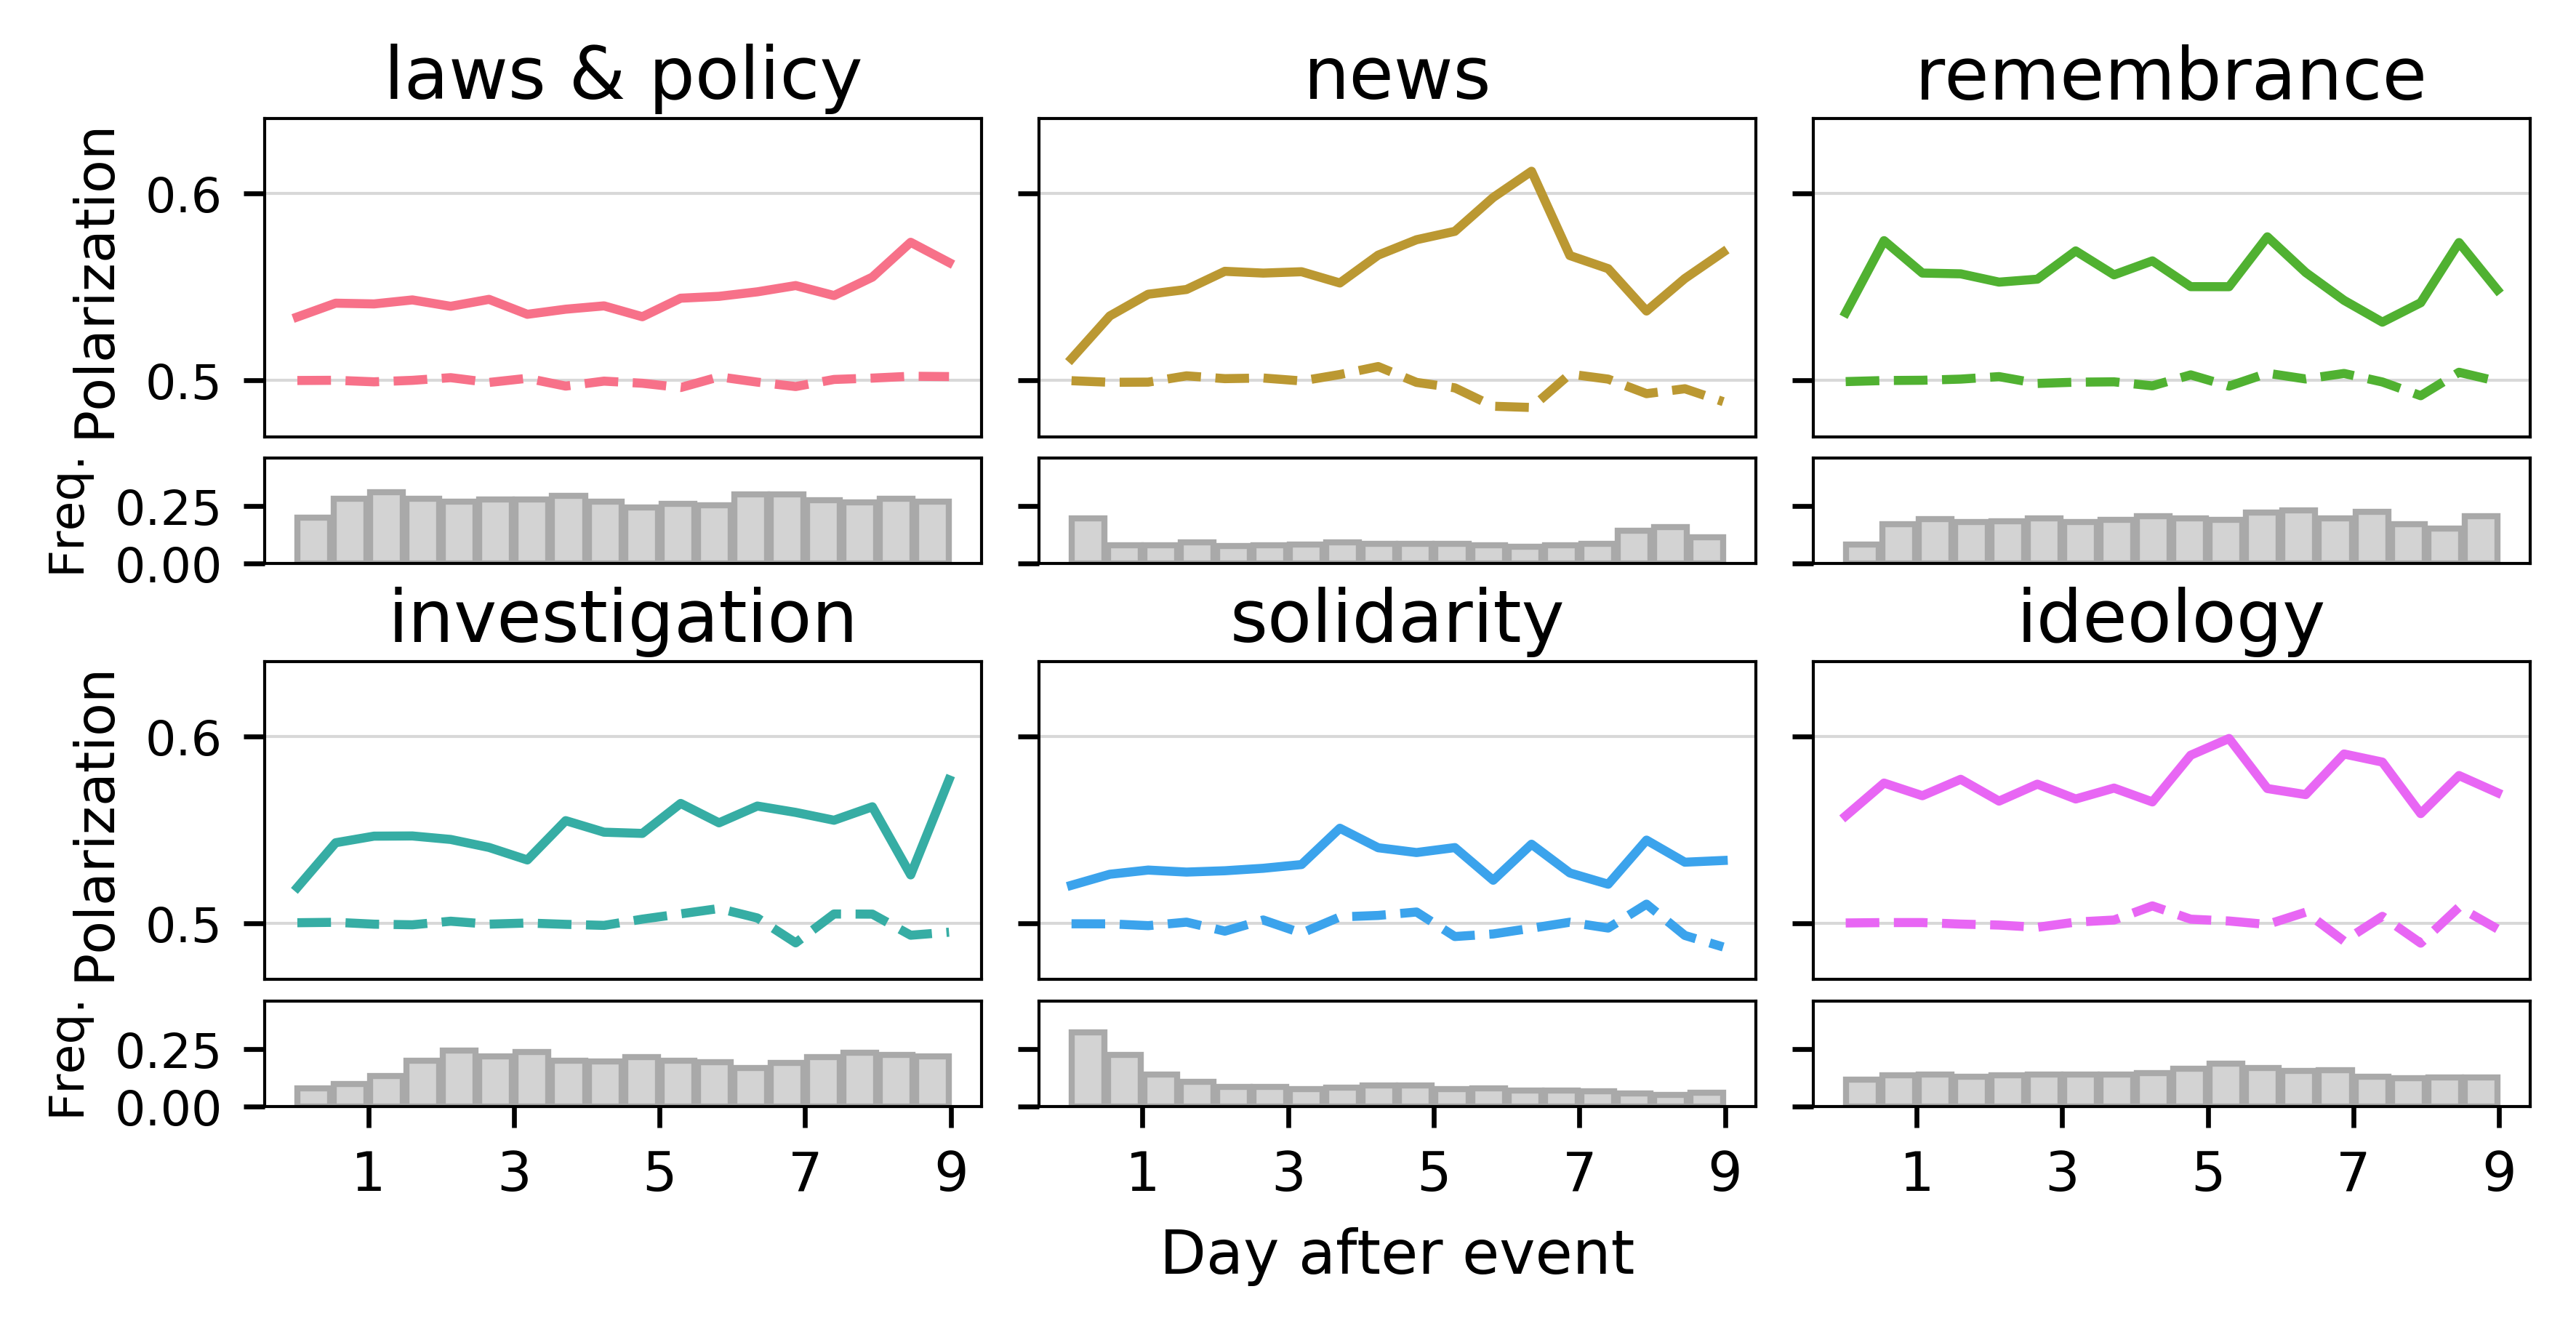

In [57]:
plot_clusters(['vegas'])  # the values from events in the list wil